In [31]:
import numpy as np 
from numpy import sqrt
import pandas as pd 
import scipy
import scipy.stats as stats
import matplotlib.pyplot as plt

In [32]:
!pip install pandas-datareader

import statsmodels.api as sm
import pandas_datareader as pdr

In [33]:
def annualize_rets(r, periods_per_year):
    """
    Annualizes a set of returns
    We should infer the periods per year
    but that is currently left as an exercise
    to the reader :-)
    """
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods)-1

def annualize_vol(r, periods_per_year):
    """
    Annualizes the vol of a set of returns
    We should infer the periods per year
    but that is currently left as an exercise
    to the reader :-)
    """
    return r.std()*(periods_per_year**0.5)

def sharpe_ratio(r, riskfree_rate, periods_per_year):
    """
    Computes the annualized sharpe ratio of a set of returns
    """
    # convert the annual riskfree rate to per period
    rf_per_period = (1+riskfree_rate)**(1/periods_per_year)-1
    excess_ret = r - rf_per_period
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
    ann_vol = annualize_vol(r, periods_per_year)
    return ann_ex_ret/ann_vol

def drawdown(return_series: pd.Series):
    """Takes a time series of asset returns.
       returns a DataFrame with columns for
       the wealth index, 
       the previous peaks, and 
       the percentage drawdown
    """
    wealth_index = 1000*(1+return_series).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks
    return pd.DataFrame({"Wealth": wealth_index, 
                         "Previous Peak": previous_peaks, 
                         "Drawdown": drawdowns})

def summary_stats(r, riskfree_rate=0.03):
    """
    Return a DataFrame that contains aggregated summary stats for the returns in the columns of r
    """
    ann_r = r.aggregate(annualize_rets, periods_per_year=12)
    ann_vol = r.aggregate(annualize_vol, periods_per_year=12)
    ann_sr = r.aggregate(sharpe_ratio, riskfree_rate=riskfree_rate, periods_per_year=12)
    dd = r.aggregate(lambda r: drawdown(r).Drawdown.min())
    skew = r.aggregate(lambda r: scipy.stats.skew(r))
    kurt = r.aggregate(lambda r: scipy.stats.kurtosis(r))
    return pd.DataFrame({
        "Annualized Return": ann_r,
        "Annualized Volatility": ann_vol,
        "Sharpe Ratio": ann_sr,
        "Max Drawdown": dd,
        "Skewness": skew,
        "Kurtosis": kurt
    })

def backtest_ws(r, weighting, estimation_window=60, **args):
    """
    Backtests a given weighting scheme, given some parameters:
    r : asset returns to use to build the portfolio
    estimation_window: the window to use to estimate parameters
    weighting: the weighting scheme to use, must be a function that takes "r", and a variable number of arguments
    """
    n_periods = r.shape[0]
    # list of overlapping rolling return windows for estimation
    windows = [(start, start+estimation_window) for start in range(n_periods-estimation_window)]
    # list of portfolio weights over time
    weights = [weighting(r.iloc[win[0]:win[1]], **args) for win in windows]
    # convert to DataFrame
    weights = pd.DataFrame(weights, index=r.iloc[estimation_window-1:-1].index, columns=r.columns)
    returns = (weights * r.shift(-1)).sum(axis="columns",  min_count=1) #mincount is to generate NAs if all inputs are NAs
    return returns

def weight_ew(r):
    """
    Returns the weights of the EW portfolio based on the asset returns "r" as a DataFrame.
    """
    n = len(r.columns)
    return pd.Series(1/n, index=r.columns)

def turnover(r):
    df = r-r.shift(1)
    df = df.dropna()
    sumx = df.sum(axis = 1)
    sum = sumx.sum()
    turnover = sum/len(sumx)
    return turnover

def parity_weight(r):
    standard_deviation = r.std()
    weights = standard_deviation**-1/(1/standard_deviation).sum()
    return weights

def weight_60_40(r):
    return pd.Series([0.6, 0.4], index=r.columns)

In [34]:
start_date = "1990-01-01"
end_date = "2022-12-30"
ff_data = pdr.get_data_famafrench("F-F_Research_Data_5_Factors_2x3_daily", start=start_date, end=end_date)
ff_factors = ff_data[0].rename(columns={"Mkt-RF": "Market", "SMB": "Size", "HML": "Value", "RMW": "Profitability", "CMA": "Investment","RF": "Risk-Free"}) / 100
ff_factors.head()

,Market,Size,Value,Profitability,Investment,Risk-Free
Date,,,,,,
1990-01-02,0.0144,-0.0067,-0.0007,0.0019,-0.0044,0.00026
1990-01-03,-0.0006,0.0072,-0.0026,0.0014,-0.0043,0.00026
1990-01-04,-0.0071,0.0044,-0.0022,-0.0006,-0.0003,0.00026
1990-01-05,-0.0085,0.0074,-0.0021,-0.0001,-0.0012,0.00026
1990-01-08,0.0030,-0.0040,-0.0026,0.0006,0.0031,0.00026


In [35]:
ff_factors_monthly = ff_factors.resample('M').last()
ff_factors_monthly

,Market,Size,Value,Profitability,Investment,Risk-Free
Date,,,,,,
1990-01-31,0.0167,-0.0123,-0.0016,-0.0008,-0.0003,0.00026
1990-02-28,0.0053,0.0014,-0.0014,-0.0017,-0.0032,0.00030
1990-03-31,-0.0018,0.0033,0.0001,-0.0027,0.0001,0.00029
1990-04-30,0.0045,-0.0030,-0.0063,0.0013,-0.0020,0.00034
1990-05-31,0.0007,0.0004,-0.0016,0.0000,-0.0010,0.00031
...,...,...,...,...,...,...
2022-08-31,-0.0074,0.0022,-0.0044,-0.0063,-0.0012,0.00008
2022-09-30,-0.0142,0.0059,0.0027,-0.0067,-0.0010,0.00009
2022-10-31,-0.0067,0.0046,0.0074,-0.0021,0.0048,0.00011


##  $$ Question 1.1 $$
***
Use the excel file named ”Countries-data”, which contains annualized monthly returns for different
country indeces. In the file ”Countries” you will find the set of six countries you must use
for the analysis, labeled as your university ID number.
***

In [36]:
DF = pd.read_excel(r"C:\Users\marco\OneDrive\NOVA\ASSET MANAGEMENT\Assignment 1\Data\Country-data.xlsx", skiprows=2,index_col = "Unnamed: 0")
DF.index = pd.to_datetime(DF.index, format = "%Y%m") 
DF.index= DF.index.to_period('M')
DF

,US,Australia,New Zealand,Canada,Denmark,DM / Euro,Japan,Sweden,Switzerland,UK,US risk-free rate
1991-01,0.047783,0.059535,0.074312,0.000366,0.028922,0.027465,0.028567,0.158023,0.056644,0.037934,0.0052
1991-02,0.069188,0.074751,0.085922,0.067323,0.101740,0.070520,0.126241,0.079044,0.068559,0.081162,0.0048
1991-03,0.024439,0.016401,-0.062463,-0.001202,-0.089755,-0.133675,-0.062067,-0.038211,-0.047861,-0.052432,0.0044
1991-04,0.003978,0.080507,0.090189,0.011505,-0.033902,0.035127,0.025023,-0.059271,0.003325,-0.012987,0.0053
1991-05,0.041617,-0.028334,0.040507,0.036420,0.039441,0.064960,-0.004475,0.079355,0.041366,0.006815,0.0047
...,...,...,...,...,...,...,...,...,...,...,...
2009-08,0.034780,0.082096,0.069268,-0.014216,0.079303,0.041700,0.039368,0.053988,0.065108,0.055345,0.0001
2009-09,0.038789,0.116440,0.078445,0.072807,0.020568,0.058372,-0.016761,0.008788,0.036423,0.027871,0.0001
2009-10,-0.019370,0.000665,0.013744,-0.051228,-0.028363,-0.039801,-0.025081,0.046070,0.004732,0.012868,0.0000
2009-11,0.059494,0.031088,-0.050108,0.074497,0.032308,0.051389,-0.010262,-0.000244,0.016702,0.029078,0.0000


In [37]:
countries = pd.read_excel(r"C:\Users\marco\OneDrive\NOVA\ASSET MANAGEMENT\Assignment 1\Data\Countries.xlsx")
my_id = 55724
countries = countries[countries["ID number"] == my_id]
countries.set_index("ID number")

,1,2,3,4,5,6
ID number,,,,,,
55724,Denmark,DM / Euro,Sweden,Australia,Canada,Switzerland


In [38]:
df = DF[["Denmark","DM / Euro","Sweden","Australia","Canada","Switzerland"]]
df

,Denmark,DM / Euro,Sweden,Australia,Canada,Switzerland
1991-01,0.028922,0.027465,0.158023,0.059535,0.000366,0.056644
1991-02,0.101740,0.070520,0.079044,0.074751,0.067323,0.068559
1991-03,-0.089755,-0.133675,-0.038211,0.016401,-0.001202,-0.047861
1991-04,-0.033902,0.035127,-0.059271,0.080507,0.011505,0.003325
1991-05,0.039441,0.064960,0.079355,-0.028334,0.036420,0.041366
...,...,...,...,...,...,...
2009-08,0.079303,0.041700,0.053988,0.082096,-0.014216,0.065108
2009-09,0.020568,0.058372,0.008788,0.116440,0.072807,0.036423
2009-10,-0.028363,-0.039801,0.046070,0.000665,-0.051228,0.004732
2009-11,0.032308,0.051389,-0.000244,0.031088,0.074497,0.016702


***
Present annualized performance statistics (average return, standard deviation, Sharpe ratio,
max drawdown, skewness, kurtosis) for an equal-weighted portfolio of the six countries (denoted
EW6).
***

,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Skewness,Kurtosis
Equal Weighted Portfolio,0.127628,0.181655,0.608826,-0.568291,-0.958606,2.808395


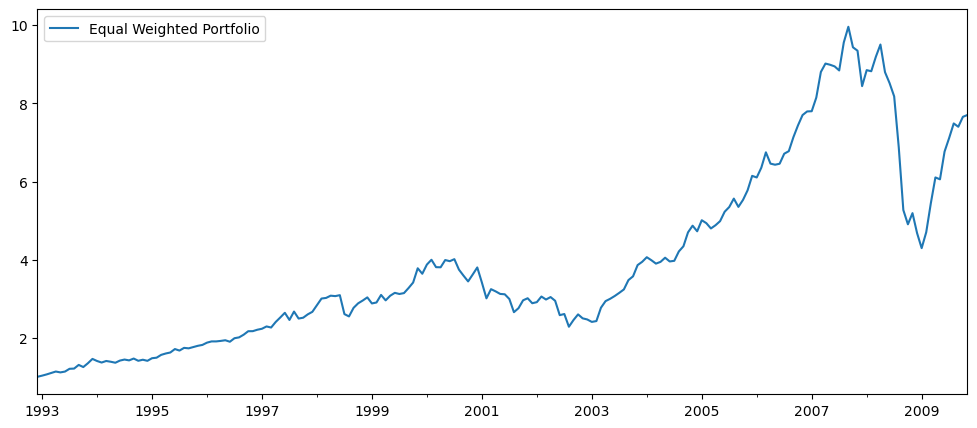

In [39]:
rf_returns = DF["US risk-free rate"]

ew6_returns = backtest_ws(df, weighting = weight_ew, estimation_window=24)

ew6_returns_df = pd.DataFrame({"Equal Weighted Portfolio":ew6_returns.dropna()})
ew6_cumulative_returns=(1+ew6_returns_df.dropna()).cumprod()
ew6_cumulative_returns.plot(figsize=(12,5))

ew6_stats = summary_stats(ew6_returns_df.dropna(), riskfree_rate=rf_returns)
ew6_stats


## $$ Question 1.2 $$
***
How does the performance of EW6 compare to a risk-parity portfolio of the six countries? 
***

,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Skewness,Kurtosis
Risk Parity Portfolio,0.128595,0.175625,0.634583,-0.557256,-0.963722,2.634718


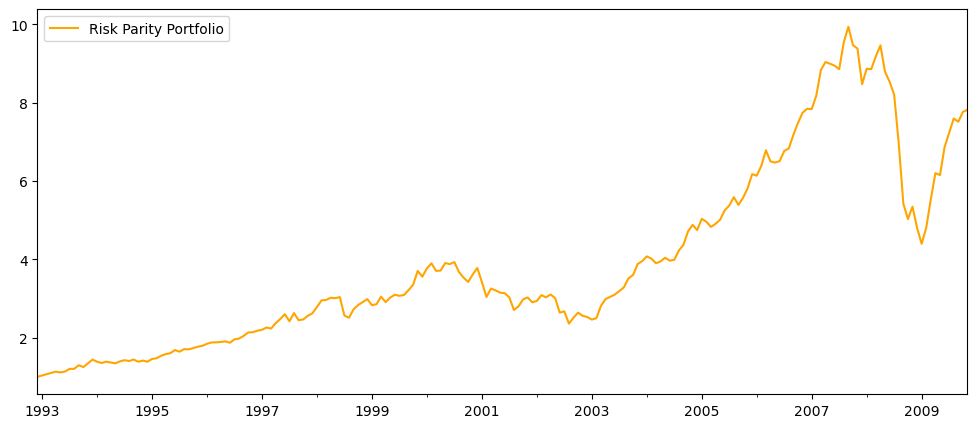

In [40]:
rp_returns = backtest_ws(df, weighting = parity_weight, estimation_window=24)

rp_returns_df = pd.DataFrame({"Risk Parity Portfolio":rp_returns})
rp_cumulative_return=(1+rp_returns_df.dropna()).cumprod()
rp_cumulative_return.plot(figsize=(12,5), color = "orange")

rp_stats = summary_stats(rp_returns_df.dropna(), riskfree_rate=rf_returns)
rp_stats

,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Skewness,Kurtosis
Equal Weighted Portfolio,0.127628,0.181655,0.608826,-0.568291,-0.958606,2.808395
Risk Parity Portfolio,0.128595,0.175625,0.634583,-0.557256,-0.963722,2.634718


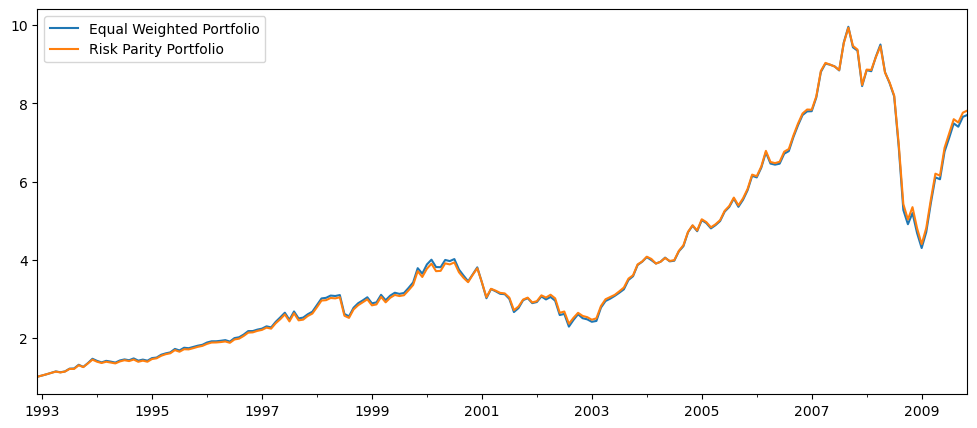

In [41]:
x = ew6_cumulative_returns
y = rp_cumulative_return
paragone = pd.concat([x,y])
paragone.plot(figsize=(12,5))
pd.concat([ew6_stats,rp_stats])

***
The graph above shows that the Risk Parity Portfolio has a greater Sharpe ratio and a higher annualised return than the Equal Weighted Portfolio. Because it is meant to balance risk, a risk parity portfolio performs better during periods of extreme volatility or market volatility. Overall, our data collection includes two big events that had a considerable influence on the markets: the DotCom Bubble and the 2008 Financial Crisis. The risk parity portfolio has more volatility and skewness since it is a riskier strategy that produces a larger turnover but generally implies negative weights and leverage, and so the probability of underestimating bad occurrences is higher. Moreover, for the sake of diversity, analyse the correlation among the six nations in the portfolio. There is minimal to no variety in this scenario because all nations, namely: Denmark; Sweden Australia, Canada, and Switzerland are all advanced economies. If we had also included emerging nations, the diversification would have grown as the correlation decreased; in this instance, the equal weighted portfolio would have done better.
***

## $$ Question 1.3 $$
***
Construct a constant re-balancing portfolio which at each period invests 60% in EW and 40% in the US risk-free rate. Further, construct a volatility-timing strategy that at time t invests 60% + Δt in EW and the remaining
in the risk-free.
***

In [42]:
ew6_rf = pd.concat([ew6_returns, rf_returns], axis=1, ignore_index=True, sort=False)
ew6_rf = ew6_rf.dropna()
ew6_rf = ew6_rf.rename(columns={0: 'EW6', 1: 'RF'})
ew6_rf

,EW6,RF
1992-12,0.010481,0.0028
1993-01,0.028289,0.0023
1993-02,0.030780,0.0022
1993-03,0.034390,0.0025
1993-04,0.033140,0.0024
...,...,...
2009-07,0.051330,0.0001
2009-08,0.052233,0.0001
2009-09,-0.011321,0.0001
2009-10,0.034290,0.0000


,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Skewness,Kurtosis
Constant Rebalancing Portfolio,0.093727,0.109468,0.729292,-0.377878,-0.972187,2.778163


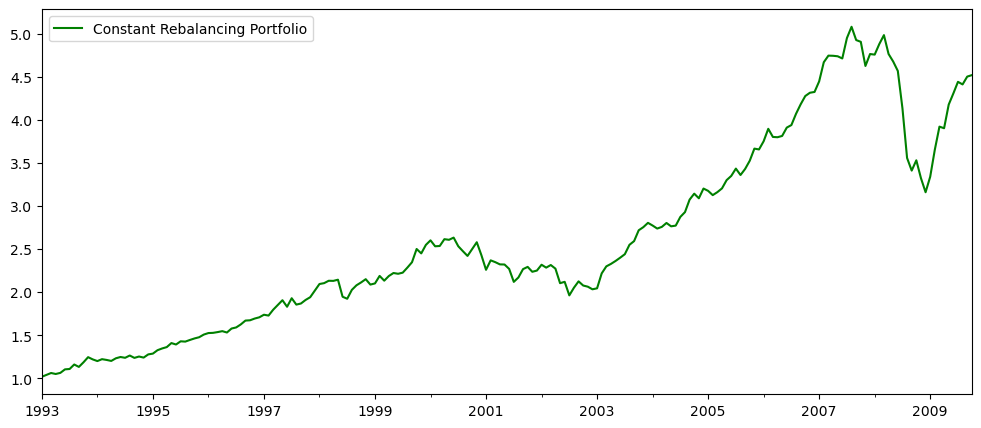

In [43]:
def weight_60_40(r, **kwargs):
    """
    Compute weights for a 60/40 portfolio, where 60 is invested in r and 40 is invested in the risk-free rate.
    """
    n_assets = r.shape[1]
    weights = np.zeros((n_assets,))
    weights[0] = 0.6
    weights[-1] = 0.4
    return weights

cr_returns = backtest_ws(ew6_rf, weighting=weight_60_40, estimation_window=2)

cr_returns_df = pd.DataFrame({"Constant Rebalancing Portfolio":cr_returns})
cr_cumulative_returns=(1+cr_returns_df.dropna()).cumprod()
cr_cumulative_returns.plot(figsize=(12,5), color = "green")

cr_stats = summary_stats(cr_returns_df.dropna(), riskfree_rate=rf_returns)
cr_stats


In [44]:
delta_t = []
for t in range(len(ew6_returns)):
    signal_t = ew6_returns.iloc[t-24:].std() - ew6_returns.iloc[:t-6].std()
    if signal_t > 0:
        delta_t.append(min(0.4, signal_t))
    else:
        delta_t.append(max(-0.4, signal_t))
delta_t_array = np.array(delta_t)

vp_weights = pd.DataFrame({'EW': 0.6 + delta_t_array, 'RF': 0.4 - delta_t_array}, index=ew6_returns.index)
vp_returns = (vp_weights['EW'] * ew6_returns[24:]) + (vp_weights['RF'] * rf_returns[24:])
vp_cumulative_returns = (1 + vp_returns).cumprod()

vp_returns_df = pd.DataFrame({"Volatility Portfolio":vp_returns})
vp_stats = summary_stats(vp_returns_df.dropna(), riskfree_rate=rf_returns)


***
How does volatility strategy perform relative to constant re-balancing?
***

,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Skewness,Kurtosis
Constant Rebalancing Portfolio,0.093727,0.109468,0.729292,-0.377878,-0.972187,2.778163
Volatility Portfolio,0.091357,0.113064,0.691417,-0.394291,-0.967953,2.974992


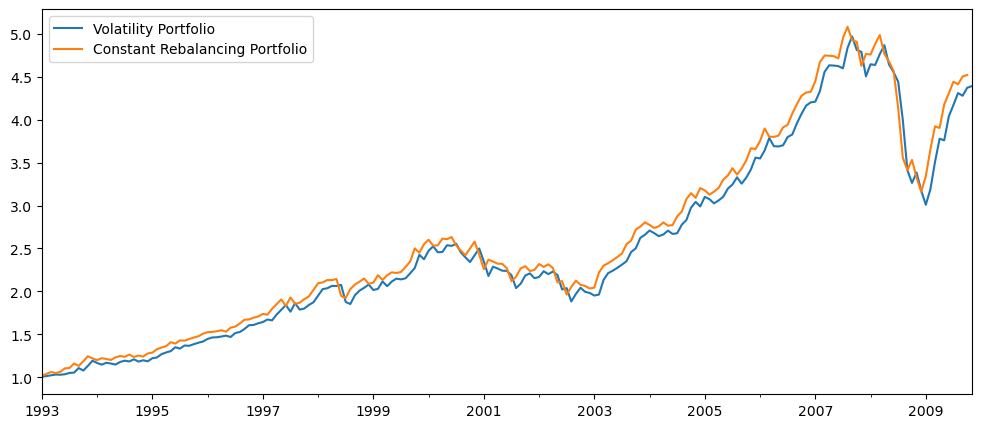

In [45]:
w = cr_cumulative_returns.dropna()
j = vp_cumulative_returns.dropna()
paragone_cr_vp = pd.concat([w,j])

z = pd.concat([j,w], axis = 1)
results = z.rename(columns = {0:"Volatility Portfolio", 1:"Costant Rebalacing Portfolio"})
results.plot(figsize=(12,5))
pd.concat([cr_stats,vp_stats])

## $$ Question 1.4 $$
***
Compute the portfolio turnover for each strategy considered so far as (EW, constant re-balancing
and volatility timing), defined as:
$$ Turnover = \frac{1}{T}\Sigma_{t=1}^T \Sigma_{i=1}^6|wi,t − wi,t−1| $$
where $T$ is the sample length.

How do the different strategies rank according to the turnover
metric?
***

In [48]:
ew6_weights = weight_ew(df).diff().abs()
n_vol = ew6_weights.shape[0]
ew6_turnover = ew6_weights.sum().sum() / n_vol 
print("The Turnover of the Equal Weighted portfolio is =",ew6_turnover)

The Turnover of the Equal Weighted portfolio is = 0.0


In [49]:
cr_weights = pd.DataFrame({'EW': 0.6, 'RF': 0.4}, index=ew6_returns.index)
n_vol = cr_weights.shape[0]
cr_weights_diff = cr_weights.diff().abs()
costant_rebalance_turnover = cr_weights_diff.sum().sum() / n_vol 
print("The Turnover of the Costant Rebalancing portfolio is =",costant_rebalance_turnover)

The Turnover of the Costant Rebalancing portfolio is = 0.0


In [50]:
vp_weights_diff = vp_weights.diff().abs()
n_vol = vp_weights_diff.shape[0]
volatility_turnover = vp_weights_diff.sum().sum() / n_vol 
print("The Turnover of the Volatility portfolio is =",volatility_turnover)

The Turnover of the Volatility portfolio is = 0.009108800541401894


## $$ Question 1.5 $$
***
Backtest the three strategies: EW, constant re-balancing and volatility timing. Comment the results in light of the performance statistics and of the turnover indicator. Discuss relative advantages and disadvantages of the strategies, both in general economic terms as well in the context of the results you have found.
***

,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Skewness,Kurtosis
Equal Weighted Portfolio,0.127850,0.182552,0.600565,-0.568291,-0.955704,2.754243
Constant Rebalancing Portfolio,0.093727,0.109468,0.729292,-0.377878,-0.972187,2.778163
Volatility Portfolio,0.091570,0.113341,0.687723,-0.394291,-0.967404,2.948627


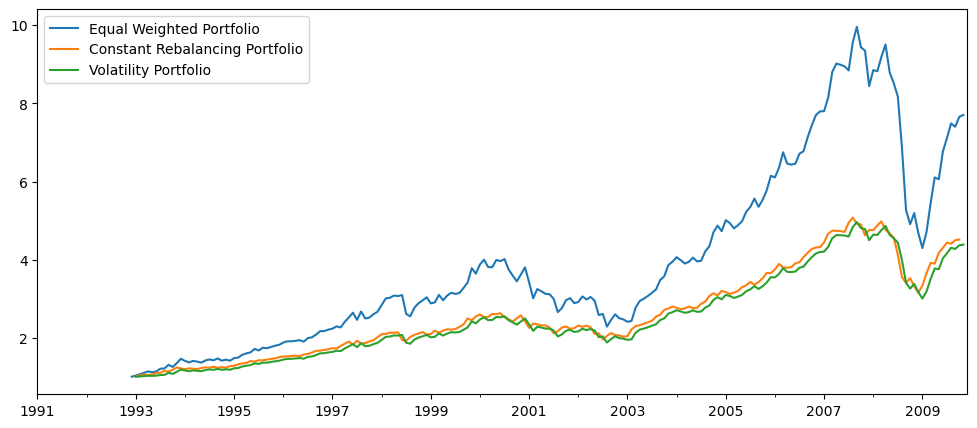

In [51]:
bt_3strategy = pd.DataFrame({"Equal Weighted Portfolio":ew6_returns,
                     "Constant Rebalancing Portfolio":cr_returns,
                     "Volatility Portfolio":vp_returns})
(1+bt_3strategy).cumprod().plot(figsize=(12,5))
summary_stats(bt_3strategy.dropna(), riskfree_rate=rf_returns)

***
A costant rebalancing method reduces variation and increases returns when compared to only investing in single stocks. It also aids in the maintenance of a target allocation. It can assist investors in sticking with a long-term investment. It is more expensive than fixed weight since it includes more tradings and hence greater transaction expenses and taxes. Rebalancing is countercyclical, which means you sell equities when they perform well and purchase when they perform poorly, which goes against human nature, which is more pro-cyclical. In the case of our portfolios, of the three techniques, portfolio rebalancing gives the highest Sharpe Ratio and hence a superior risk allocation; it hedges for the market and minimises portfolio volatility. The volatility timing method works best during moments of extreme volatility or market upheaval. It necessitates regular modifications, which might result in large transaction costs and taxes. At periods of low and consistent volatility, it may not be the best option. In this scenario, as with the costant rebalancing technique, it provides a better risk allocation and hence a higher Sharpe ratio as compared to an equal weighted portfolio with lower volatility. Instead, the constant weight approach produces a higher annualised return but a lower sharpe ratio since it does not hedge the market with a risk-free rate. In general, the equal weighted portfolio approach is the least expensive since it does not need frequent trading and hence has reduced transaction costs. Also, it has a lesser diversification advantage, which means it may underperform during market downturns.
***

## $$ Qestion 2.1 $$
***
For this exercise use the file ”Tickers”, which specifies the tickers of the 50 stocks you should
use, given your university ID. Further, use the file ”ESG-score” to get the ESG score of each of
the stocks in your portfolio of 50 stocks. Retrieve returns for your 50 stocks, for instance using
YFinance API in Python, from 1990. Present annualized performance statistics.
***

In [52]:
!pip install yfinance
import yfinance as yf

In [53]:
DF1 = pd.read_excel(r"C:\Users\marco\OneDrive\NOVA\ASSET MANAGEMENT\Assignment 1\Data\Tickers.xlsx")
ticker = DF1[DF1["ID number"] == my_id]
ticker = ticker.set_index("ID number").values
ticker=ticker.reshape(50,1)

In [54]:
df1=pd.read_excel(r'C:\Users\marco\OneDrive\NOVA\ASSET MANAGEMENT\Assignment 1\Data\ESG score.xlsx')
df1=df1[df1['Ticker'].isin(ticker[:,0])]
df1.head()

,Identifier (RIC),Ticker,Company Name,ISIN Code,TRBC Industry Name,TRBC Industry Code,ESG Score Grade\n(FY0),ESG Score\n(FY0)
5,CE.N,CE,Celanese Corp,US1508701034,Commodity Chemicals,51101010,B+,70.391208
8,FIS.N,FIS,Fidelity National Information Services Inc,US31620M1062,Financial Technology (Fintech),57301010,B+,72.744345
10,AMP.N,AMP,Ameriprise Financial Inc,US03076C1062,Investment Management & Fund Operators,55102020,A-,78.639650
23,PFG.OQ,PFG,Principal Financial Group Inc,US74251V1026,Investment Management & Fund Operators,55102020,B+,74.459912
27,CNC.N,CNC,Centene Corp,US15135B1017,Managed Healthcare,56102020,B+,72.704668


In [55]:
tickers = df1["Ticker"].values.tolist()
tickers_str = ' '.join(tickers)

In [56]:
start_date = "1990-01-01"
end_date = "2022-12-30"
DF2= yf.download(tickers_str, start=start_date, end=end_date)
prices = DF2["Adj Close"]

[*********************100%***********************]  50 of 50 completed


In [57]:
stock_returns = prices.pct_change()
stock_statistic = summary_stats(stock_returns.dropna(), riskfree_rate=ff_factors["Risk-Free"])
stock_statistic.head()

,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Skewness,Kurtosis
AAL,-0.011959,0.137865,-0.012399,-0.794354,1.477579,17.512724
ABBV,0.007429,0.059021,0.017668,-0.369657,-1.098864,12.156315
ACGL,0.008645,0.072131,0.016829,-0.538398,-0.300914,11.795218
ADM,0.008601,0.060676,0.019904,-0.405223,-0.310282,5.195376
ALLE,0.003666,0.066519,0.007700,-0.432501,-0.142701,7.076490


## $$ Question 2.2 $$
***
Absolutely, measuring ESG ratings at the conclusion of the sample period can have an influence on backtesting analysis. The first thing to remember is that ESG ratings are susceptible to change, and a company's ESG performance at the conclusion of the sample period may differ from what it was at the start. As a result, there might be a mismatch between the ESG score used in the backtesting research and the company's actual ESG performance at the time. This might lead to inaccurate judgements about the effectiveness of an investment plan. Also, we must keep in mind that a year is a very long period of time. If a corporation had a very good ESG score at the start of the year, but a significant event or societal scandal occurred throughout the year, the ESG score would suffer. As a result, if a company's ESG score falls within the sample period, an investment strategy that was successful early in the time may become less effective or even counterproductive at the end of the period. Finally, adopting end-of-period ESG ratings may result in a delay between the implementation of an investment strategy and the measurement of its ESG impact. For example, if ESG scores are only recorded at the end of the period but the investment strategy is adopted at the beginning, there may be a delay of several weeks or even years before the impact of the investment strategy on ESG performance can be evaluated. Therefore, while doing a backtesting study utilising an ESG score, we should carefully analyse the aforementioned aspects and their potential effects on the success of the techniques used.
***

## $$ Question 2.3 $$
***
Build an equal weighted portfolio EW. Further design an additional ”Green” portfolio, where
the EW portfolio is tilted toward stocks with high ESG scores. The ”Green” portfolio is targeted
to clients that care about ESG pillars, beyond the risk-return trade-off. As a portfolio manager,
you are given full flexibility in designing such portfolio. Discuss your choice and the trade-off
you face taking into account: performance, traction to ethics-driven investors as well as practical
implementation issues.
***

,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Skewness,Kurtosis
Equal Weighted Portfolio 2,0.006177,0.037388,0.162531,-0.47357,-0.170272,17.031204


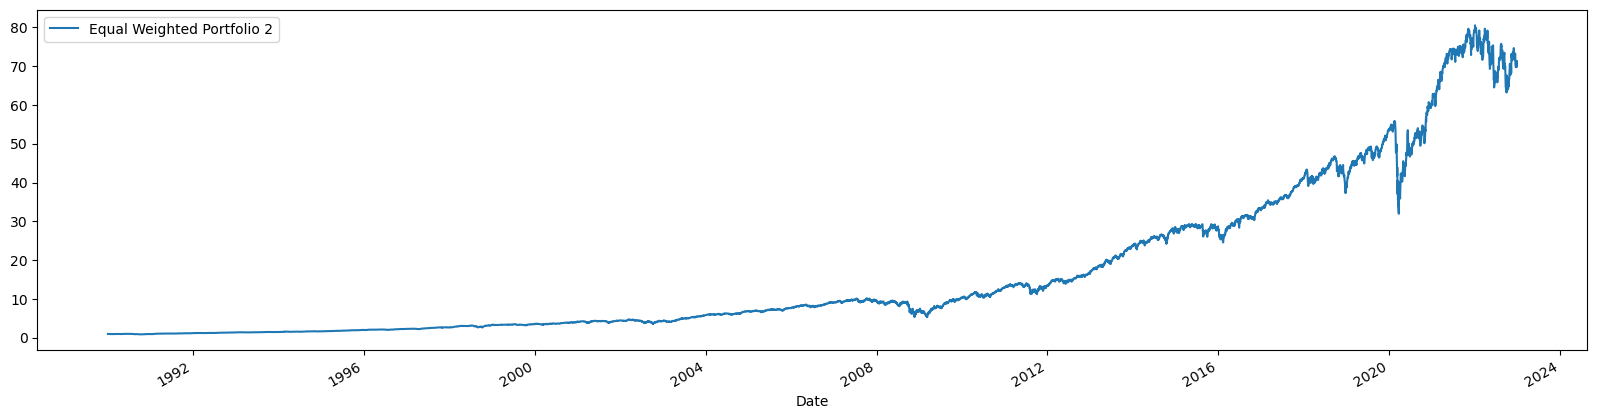

In [58]:
ew2_weights = weight_ew(stock_returns)

ew2_returns = (stock_returns * ew2_weights).sum(axis = 1)
ew2_returns_df = pd.DataFrame({"Equal Weighted Portfolio 2":ew2_returns})
ew2_cumulative_returns= (1+ew2_returns_df).cumprod()
ew2_cumulative_returns.plot(figsize = (20,5)) 
summary_stats(ew2_returns_df.dropna(), riskfree_rate=ff_factors["Risk-Free"])

In [59]:
esg_portfolio = df1[df1['ESG Score\n(FY0)'] >= 75]
esg_tickers = esg_portfolio['Ticker'].values.tolist()

start_date = "1990-01-01"
end_date = "2022-03-04"
DF2 = yf.download(esg_tickers, start=start_date, end=end_date)
esg_prices = DF2["Adj Close"]
DF2.head()

[*********************100%***********************]  16 of 16 completed


Adj Close                                                  \
                ABBV       ADM AMP AMT      CDNS       DXC         F   
Date                                                                   
1990-01-02       NaN  4.708868 NaN NaN  4.888889  2.938935  2.527367   
1990-01-03       NaN  4.708868 NaN NaN  5.027778  2.919808  2.541329   
1990-01-04       NaN  4.683275 NaN NaN  4.916667  2.868808  2.541329   
1990-01-05       NaN  4.478542 NaN NaN  4.888889  2.856057  2.506421   
1990-01-08       NaN  4.529727 NaN NaN  5.000000  2.900683  2.506421   

                                          ...   Volume                  \
                FITB       HST       HSY  ...        F    FITB     HST   
Date                                      ...                            
1990-01-02  2.102227  1.893418  4.318484  ...  6241908  164025  454000   
1990-01-03  2.092628  1.900536  4.288700  ...  8032278  250594  628721   
1990-01-04  2.092628  1.879183  4.258919  ...  3932566  150356  216911   
1990-01-05  2.102227  1.886300  4.229133  ...  3820771   53536  236974   
1990-01-08  2.078229  1.893418  4.214244  ...  3360985  142383  224822   

                                                      
               HSY        J KMI  MA TSCO URI     WST  
Date                                                  
1990-01-02  530800   248000 NaN NaN  NaN NaN   14800  
1990-01-03  619600   209600 NaN NaN  NaN NaN   33200  
1990-01-04  719600   716800 NaN NaN  NaN NaN   21600  
1990-01-05  307200  1193600 NaN NaN  NaN NaN  110800  
1990-01-08  312400   952000 NaN NaN  NaN NaN   27600  

[5 rows x 96 columns]

,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Skewness,Kurtosis
ESG Portfolio,0.006743,0.041681,0.155345,-0.5568,0.104455,17.715893


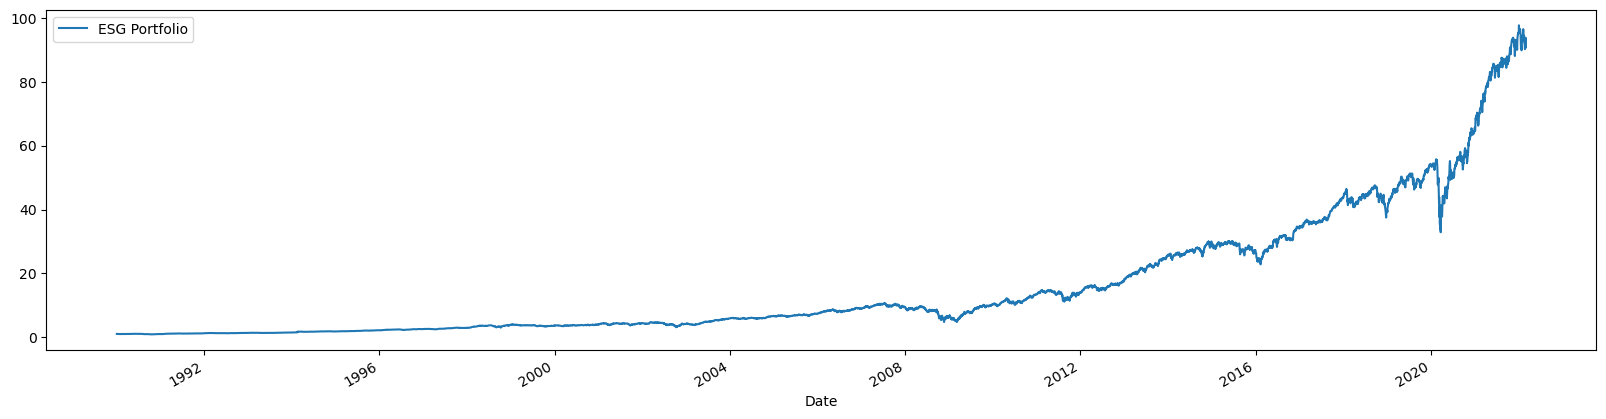

In [60]:
esg_return = esg_prices.pct_change()
esg_weights = weight_ew(esg_return)

esg_returns = (esg_return * esg_weights).sum(axis = 1)
esg_returns_df = pd.DataFrame({"ESG Portfolio":esg_returns})
esg_cumulative_returns= (1+esg_returns_df).cumprod()
esg_cumulative_returns.plot(figsize = (20,5)) 
summary_stats(esg_returns_df.dropna(), riskfree_rate=ff_factors["Risk-Free"])

In [61]:
def weight_40_60(r, **kwargs):
    """
    Compute weights for a 60/40 portfolio, where 60 is invested in r and 40 is invested in the risk-free rate.
    """
    n_assets = r.shape[1]
    weights = np.zeros((n_assets,))
    weights[0] = 0.4 
    weights[-1] = 0.6 
    return weights

In [62]:
ew2_rf = pd.concat([ew2_returns, ff_factors['Risk-Free']], axis=1, ignore_index=True, sort=False)
ew2_rf = ew2_rf.dropna()
ew2_rf = ew2_rf.rename(columns={0: 'EW2', 1: 'RF'})
ew2_rf

,EW2,RF
Date,,
1990-01-02,0.000000,0.00026
1990-01-03,-0.000528,0.00026
1990-01-04,-0.003821,0.00026
1990-01-05,-0.001974,0.00026
1990-01-08,0.001387,0.00026
...,...,...
2022-12-22,-0.011247,0.00016
2022-12-23,0.008541,0.00016
2022-12-27,0.002045,0.00016


,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Skewness,Kurtosis
Green Portfolio,0.003375,0.014971,0.218169,-0.201612,-0.19117,17.008375


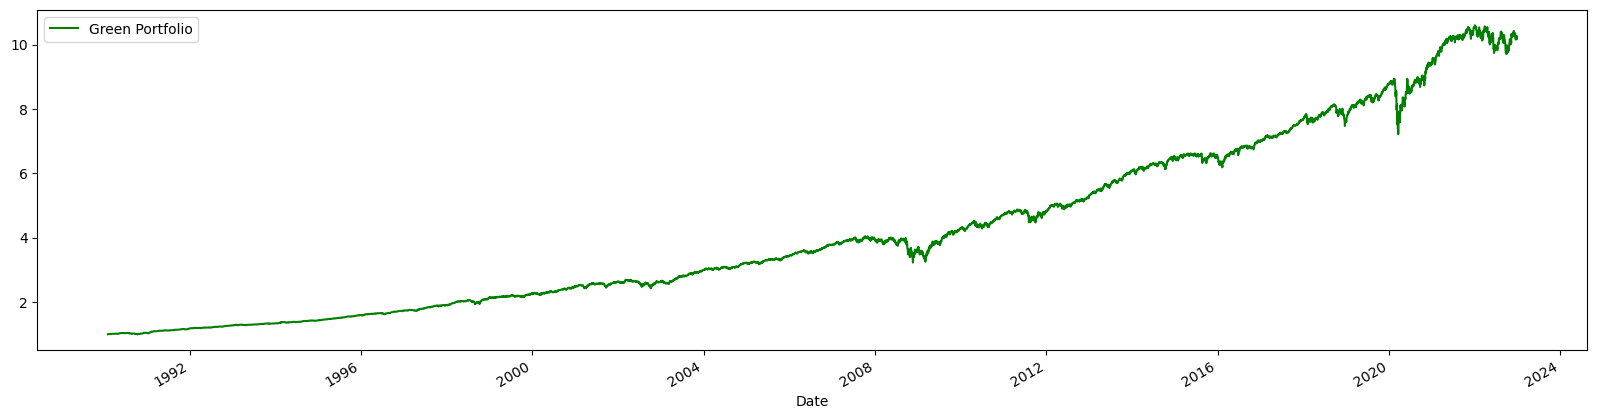

In [63]:
gp_returns = backtest_ws(ew2_rf, weighting=weight_40_60, estimation_window=24)

gp_returns_df = pd.DataFrame({"Green Portfolio":gp_returns})
gp_cumulative_returns=(1+gp_returns_df).cumprod()
gp_cumulative_returns.plot(figsize=(20,5), color = "green")

gp_stats = summary_stats(gp_returns_df.dropna(), riskfree_rate=ff_factors['Risk-Free'])
gp_stats

***
While creating the "Green" portfolio, we made the decision to weight equities with better ESG scores more heavily than firms with lower ESG scores. The growing significance of ESG considerations in investing and the need to appeal to investors who are motivated by ethics were the driving forces behind this choice. We intended to build a portfolio that fit with investors' values and beliefs while still attaining a respectable level of performance by including ESG variables into the portfolio creation process.
Annualized return, volatility, and Sharpe ratio measurements of the "Green" portfolio's performance revealed that it underperformed the equal-weighted and ESG portfolios. The portfolio nevertheless outperformed the ESG portfolio in terms of risk-adjusted performance as indicated by the Sharpe ratio, though. A lower degree of risk was also shown by the "Green" portfolio's significantly smaller maximum drawdown when compared to the other portfolios.
The choice of the ESG score system, as well as data availability and quality, were practical implementation problems while building the "Green" portfolio. The precise ESG concerns of our clients may not have been correctly captured by the third-party ESG rating supplier that we employed. Also, although it might not have been the best strategy, we tipped towards equities with higher ESG scores using an equal-weighted method. It was possible to utilise a more complex optimization technique, but doing so would have made the process of building a portfolio more difficult.
In conclusion, the "Green" portfolio was created to appeal to investors that place a premium on morality while still delivering a respectable degree of return. Despite the portfolio's somewhat worse performance than the other portfolios, investors looking for a more conservative investing strategy may find its higher Sharpe ratio and lower degree of risk to be appealing. The portfolio's capacity to effectively represent the ESG concerns of our clients may be impacted by the careful attention given to data availability, quality, and methodology throughout the practical implementation of the portfolio.
***

## $$ Question 2.4 $$
***
Run performance analysis of your EW and Green portfolio, first against CAPM and then FF5.
Compute alpha, tracking error and information ratio. Comment your results.
***

In [64]:
mkt_excess = ff_factors[['Market']]
mkt_excess

,Market
Date,
1990-01-02,0.0144
1990-01-03,-0.0006
1990-01-04,-0.0071
1990-01-05,-0.0085
1990-01-08,0.0030
...,...
2022-12-23,0.0051
2022-12-27,-0.0051
2022-12-28,-0.0123


In [65]:
dependent_variable = ew2_rf['EW2'] - ew2_rf['RF']
dependent_variable

Date
1990-01-02   -0.000260
1990-01-03   -0.000788
1990-01-04   -0.004081
1990-01-05   -0.002234
1990-01-08    0.001127
                ...   
2022-12-22   -0.011407
2022-12-23    0.008381
2022-12-27    0.001885
2022-12-28   -0.013159
2022-12-29    0.020253
Length: 8314, dtype: float64

In [66]:
independent_variable = mkt_excess
independent_variable

,Market
Date,
1990-01-02,0.0144
1990-01-03,-0.0006
1990-01-04,-0.0071
1990-01-05,-0.0085
1990-01-08,0.0030
...,...
2022-12-23,0.0051
2022-12-27,-0.0051
2022-12-28,-0.0123


In [67]:
independent_variable = sm.add_constant(independent_variable)
independent_variable = independent_variable.iloc[:-1]

In [68]:
capm_model = sm.OLS(dependent_variable, independent_variable).fit()

In [69]:
capm_beta_ew = capm_model.params['Market']
capm_alpha_ew = capm_model.params['const']

In [70]:
capm_returns_ew = ew2_rf['RF'] + capm_alpha_ew + capm_beta_ew * ff_factors['Market']

In [71]:
capm_tracking_error_ew = np.std(ew2_rf['EW2'] - capm_returns_ew)
capm_information_ratio_ew = (ew2_rf['EW2'] - capm_returns_ew).mean() / capm_tracking_error_ew

In [72]:
green_excess_returns = gp_returns - ff_factors['Risk-Free']
green_excess_returns =  green_excess_returns.dropna()

In [73]:
from sklearn.linear_model import LinearRegression

In [74]:
reg = LinearRegression().fit(mkt_excess.iloc[23:-2], green_excess_returns)
capm_beta_green = reg.coef_[0]
capm_alpha_green = reg.intercept_

In [75]:
green_predicted_returns = reg.predict(mkt_excess.iloc[23:-2])
capm_tracking_error_green = np.std(green_excess_returns - green_predicted_returns)

In [76]:
capm_information_ratio_green = capm_alpha_green / capm_tracking_error_green

In [77]:
capm_results = pd.DataFrame({
    'Portfolio': ['Equal Weighted', 'Green'],
    'CAPM Beta': [capm_beta_ew, capm_beta_green],
    'CAPM Alpha': [capm_alpha_ew, capm_alpha_green],
    'Tracking Error': [capm_tracking_error_ew, capm_tracking_error_green],
    'Information Ratio': [capm_information_ratio_ew, capm_information_ratio_green]
})

capm_results.set_index('Portfolio', inplace=True)
capm_results['CAPM Alpha'] = capm_results['CAPM Alpha'].apply(lambda x: '{:.2f}%'.format(x*100))
capm_results['Tracking Error'] = capm_results['Tracking Error'].apply(lambda x: '{:.2f}%'.format(x*100))

capm_results

,CAPM Beta,CAPM Alpha,Tracking Error,Information Ratio
Portfolio,,,,
Equal Weighted,0.851155,0.02%,0.45%,-6.167380e-17
Green,-0.017762,0.02%,0.43%,4.584636e-02


In [78]:
ew_portfolio = ew2_returns_df.dropna()
gp_portfolio = gp_returns_df.dropna()

In [79]:
ew_portfolio = ew_portfolio.rename(columns={0: "Returns"})
gp_portfolio = gp_portfolio.rename(columns={0: "Returns"})

ew_ff = pd.merge(ew_portfolio, ff_factors, how='left', left_index=True, right_index=True)
gp_ff = pd.merge(gp_portfolio, ff_factors, how='left', left_index=True, right_index=True)

In [80]:
ew_y = ew_ff['Equal Weighted Portfolio 2']
ew_x = ew_ff[['Market', 'Size', 'Value', 'Profitability', 'Investment']]
gp_y = gp_ff['Green Portfolio']
gp_x = gp_ff[['Market', 'Size', 'Value', 'Profitability', 'Investment']]

In [81]:
ew_reg = sm.OLS(ew_y, sm.add_constant(ew_x)).fit()
gp_reg = sm.OLS(gp_y, sm.add_constant(gp_x)).fit()

In [82]:
ew_alpha, ew_beta_mkt, ew_beta_size, ew_beta_value, ew_beta_profit, ew_beta_invest = ew_reg.params
gp_alpha, gp_beta_mkt, gp_beta_size, gp_beta_value, gp_beta_profit, gp_beta_invest = gp_reg.params

In [83]:
ew_resid = ew_ff['Equal Weighted Portfolio 2'] - (ew_alpha + ew_beta_mkt*ew_ff['Market'] + ew_beta_size*ew_ff['Size'] + ew_beta_value*ew_ff['Value'] + ew_beta_profit*ew_ff['Profitability'] + ew_beta_invest*ew_ff['Investment'])
gp_resid = gp_ff['Green Portfolio'] - (gp_alpha + gp_beta_mkt*gp_ff['Market'] + gp_beta_size*gp_ff['Size'] + gp_beta_value*gp_ff['Value'] + gp_beta_profit*gp_ff['Profitability'] + gp_beta_invest*gp_ff['Investment'])

In [84]:
ew_tracking_error = np.std(ew_resid)
gp_tracking_error = np.std(gp_resid)
ew_information_ratio = ew_alpha / ew_tracking_error
gp_information_ratio = gp_alpha / gp_tracking_error

In [85]:
ew_results = {
    'Alpha': [ew_alpha*100],
    'Market Beta': [ew_beta_mkt],
    'Size Beta': [ew_beta_size],
    'Value Beta': [ew_beta_value],
    'Profitability Beta': [ew_beta_profit],
    'Investment Beta': [ew_beta_invest],
    'Tracking Error': [ew_tracking_error]
}

ew_results_df = pd.DataFrame.from_dict(ew_results)

ew_results_df.index.name = 'Equal Weighted Portfolio'
ew_results_df

,Alpha,Market Beta,Size Beta,Value Beta,Profitability Beta,Investment Beta,Tracking Error
Equal Weighted Portfolio,,,,,,,
0,0.021316,0.873111,0.25143,0.313913,0.107083,0.022675,0.003389


In [86]:
gp_results = {
    'Alpha': [gp_alpha*100],
    'Market Beta': [gp_beta_mkt],
    'Size Beta': [gp_beta_size],
    'Value Beta': [gp_beta_value],
    'Profitability Beta': [gp_beta_profit],
    'Investment Beta': [gp_beta_invest],
    'Tracking Error': [gp_tracking_error]
}

gp_results_df = pd.DataFrame.from_dict(gp_results)

gp_results_df.index.name = 'Green Portfolio'
gp_results_df

,Alpha,Market Beta,Size Beta,Value Beta,Profitability Beta,Investment Beta,Tracking Error
Green Portfolio,,,,,,,
0,0.029254,-0.016805,0.031875,-0.032071,0.037628,-0.018038,0.004306


***
We have determined the Equal Weighted and Green portfolios' beta and alpha in order to do the CAPM analysis. The Equal Weighted Portfolio's beta is substantial and positive, which shows that the portfolio has a strong correlation to the market. In contrast, the Green portfolio's beta is negative, suggesting that it has a low correlation with the market. Both portfolios' alphas are negligible and modest, indicating that neither beat the market after accounting for market risk. The Green portfolio, however, has a positive Information Ratio, indicating that, after accounting for risk, it has produced extra returns as compared to the Equal Weighted portfolio. We have determined the Equal Weighted and Green portfolios' alpha, market beta, size beta, value beta, profitability beta, investment beta, and tracking error using the Fama French study. The Equal Weighted portfolio's alpha is positive and substantial, suggesting that it has outperformed the benchmark portfolio in terms of returns. The portfolio is strongly associated with the market, as seen by the positive and considerable market beta. The portfolio may have exposure to small-cap equities as the size beta is positive and strong. The portfolio has exposure to value equities, as seen by the positive and large value beta. Positive and large profitability beta indicates that the portfolio is exposed to profitable stocks. The portfolio's exposure to equities with low investment is shown by the positive and substantial investment beta. Last but not least, a low tracking error shows that the portfolio closely follows its benchmark. The Green portfolio has an alpha that is both positive and large, indicating that it has outperformed its benchmark portfolio in terms of returns. The portfolio's low correlation with the market is indicated by the market beta, which is negative and negligible. The portfolio may not have much exposure to any of these criteria, as seen by the insignificance of the size, value, and profitability betas. The portfolio's exposure to equities with low investment is shown by the positive and substantial investment beta. The tracking error is also larger for the Green portfolio than it is for the Equal Weighted portfolio, showing that it deviates from its benchmark more.
***